# Detectar arritmias cardíacas mediante señales de ECG parcialmente etiquetadas
### INF395 Introducción a las Redes Neuronales and Deep Learning
- Estudiante: Alessandro Bruno Cintolesi Rodríguez
- ROL: 202173541-0

## **1. Librerias**

In [ ]:
# === General / Utilidad ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Union

# === PyTorch, PyTorch Lightning, Torchvision ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
#from torch_audiomentations import Compose, AddColoredNoise, TimeStretch, PitchShift

# === Lightly ===
from lightly.loss import NTXentLoss

# === Scikit-learn ===
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

## **2. Variables globales**

In [2]:
# Clases
CLASSES = {
	0: "(N) Latido normal",
	1: "(S) Latido supraventricular",
	2: "(V) Latido ventricular ectópico",
	3: "(F) Latido de fusión",
	4: "(Q) Latido desconocido"
}

# Variables globales
SEED = 42
SIGNALS = 186
PROJ_DIM = 128
NUM_WORKERS = 0
BATCH_SIZE = 1024
EPOCHS = 50
LEARNING_RATE = 1e-2
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4

## **3. Setup del Dispositivo**

In [3]:
# Setup random seed
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED, workers=True)

# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
	print("GPU:", torch.cuda.get_device_name(0))

Seed set to 42


Using device: cuda
GPU: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


## **4. Funciones Auxiliares**

In [4]:
def plot_ecg(X, y, aug=False, aug_title=""):
	y_class = CLASSES.get(y, "Sin clasificar")
	title = f"ECG Clase: {y_class}"
	if aug:
		title = title + f" | {aug_title}"

	plt.plot(X)
	plt.title(title)
	plt.xlabel("Tiempo (muestras)")
	plt.ylabel("Amplitud")
	plt.show()

In [5]:
def plot_clusters(X, clusters, n_clusters):
	for i in range(n_clusters):
		cluster_mask = clusters == i
		cluster_mean = X[cluster_mask].mean(axis=0)
		plt.plot(cluster_mean, label=f"Cluster {i}")

	plt.legend()
	plt.title("Promedio de señal por cluster")
	plt.xlabel("Muestra")
	plt.ylabel("Amplitud promedio")
	plt.grid(True)
	plt.show()

## **5. Analisis Exploratorio de Datos**

In [6]:
# Read our train and test CSV
train_df = pd.read_csv("ecg_signals/train_semi_supervised.csv")
test_df = pd.read_csv("ecg_signals/test_semi_supervised.csv")

In [7]:
# Dividimos nuestros datos en X (serie de tiempo) / y (label)
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

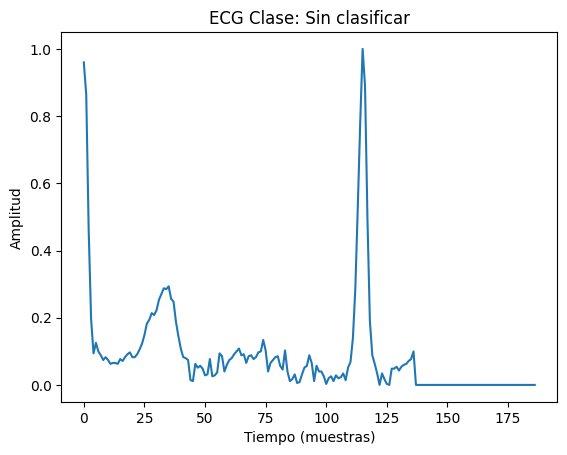

In [8]:
# Graficando un ECG
plot_ecg(X=X_train[1], y=y_train[1])

In [9]:
# Clusters con K-means
train_kmeans = KMeans(n_clusters=5, random_state=SEED)
train_clusters = train_kmeans.fit_predict(X_train)

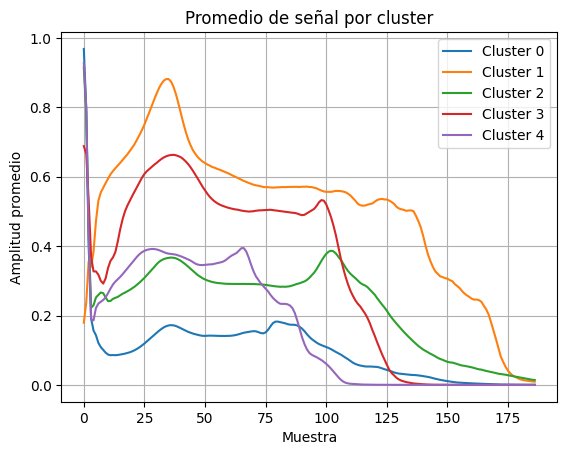

In [10]:
plot_clusters(X=X_train, clusters=train_clusters, n_clusters=5)

In [11]:
# Hacemos un conteo por clases
unique, counts = np.unique(y_train, return_counts=True)
for c, n in zip(unique, counts):
	if not np.isnan(c):
		c = int(c)
	print(f"Clase {c}: {n} muestras ({n/len(y_train)*100:.2f}%)")

Clase 0: 36236 muestras (41.39%)
Clase 1: 1112 muestras (1.27%)
Clase 2: 2894 muestras (3.31%)
Clase 3: 321 muestras (0.37%)
Clase 4: 3216 muestras (3.67%)
Clase nan: 43775 muestras (50.00%)


In [12]:
n_classes = 5

y_valid = y_train[~np.isnan(y_train)]
y_valid = y_valid[y_valid >= 0].astype(int)

print("Clases en y_valid:", np.unique(y_valid))

present_classes = np.unique(y_valid)
weights_partial = compute_class_weight(
	class_weight="balanced",
	classes=present_classes,
	y=y_valid
)

full_weights = np.zeros(n_classes, dtype=np.float32)
for c, w in zip(present_classes, weights_partial):
	full_weights[int(c)] = float(w)

class_weights = torch.tensor(full_weights, dtype=torch.float32).to(DEVICE)
print("Pesos por clase (0..4):", class_weights.cpu().numpy())

Clases en y_valid: [0 1 2 3 4]
Pesos por clase (0..4): [ 0.24163263  7.873921    3.025501   27.276636    2.7225747 ]


## **6. SimCLR**

### **6.1 Augmentaciones para SimCLR**

#### **6.1.a Augmentaciones para SimCLR utilizando Tsaug**

In [ ]:
class SimCLRTimeSeriesAugment:
	def __init__(
		self,
		series_len: int = 186,
		p_jitter: float = 0.8, jitter_sigma: float = 0.01,
		p_scaling: float = 0.8, scaling_sigma: float = 0.1,
		p_tmask: float = 0.5, tmask_frac: Tuple[float, float] = (0.03, 0.12),
		p_perm: float = 0.3, n_segments: int = 4,
		p_crop: float = 0.9, crop_frac: Tuple[float, float] = (0.8, 0.95),
		device: Union[str, torch.device, None] = None,
		return_numpy: bool = True,
		non_blocking: bool = True,
	):
		self.L = series_len
		self.p_jitter, self.jitter_sigma = p_jitter, jitter_sigma
		self.p_scaling, self.scaling_sigma = p_scaling, scaling_sigma
		self.p_tmask, self.tmask_frac = p_tmask, tmask_frac
		self.p_perm, self.n_segments = p_perm, n_segments
		self.p_crop, self.crop_frac = p_crop, crop_frac

		# device agnóstico por defecto
		if device is None:
			device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
		self.device = torch.device(device)
		self.return_numpy = return_numpy
		self.non_blocking = non_blocking

	def _as_tensor(self, x: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
		# Convierte y mueve al device elegido
		if isinstance(x, torch.Tensor):
			# si ya está en device, solo nos aseguramos del dtype
			if x.dtype != torch.float32:
				x = x.to(torch.float32)
			return x.to(self.device, non_blocking=self.non_blocking)
		else:
			# numpy -> tensor en device
			t = torch.as_tensor(x, dtype=torch.float32)
			return t.to(self.device, non_blocking=self.non_blocking)

	def _to_output(self, x: torch.Tensor) -> Union[np.ndarray, torch.Tensor]:
		# Devuelve en el formato deseado
		if self.return_numpy:
			return x.detach().to("cpu").numpy()
		return x

	def _rand(self, *size) -> torch.Tensor:
		return torch.rand(size, device=self.device)

	def _randint(self, low: int, high: int, size=(1,)) -> torch.Tensor:
		# high es exclusivo en torch.randint
		high = max(low + 1, high)
		return torch.randint(low, high, size, device=self.device)

	def _jitter(self, x: torch.Tensor) -> torch.Tensor:
		if self._rand(1) < self.p_jitter:
			x = x + torch.randn_like(x) * self.jitter_sigma
		return x

	def _scaling(self, x: torch.Tensor) -> torch.Tensor:
		if self._rand(1) < self.p_scaling:
			f = 1.0 + torch.randn(1, device=self.device) * self.scaling_sigma
			x = x * f
		return x

	def _time_mask(self, x: torch.Tensor) -> torch.Tensor:
		if self._rand(1) < self.p_tmask:
			L = x.shape[-1]
			w_min = int(self.tmask_frac[0] * L)
			w_max = int(self.tmask_frac[1] * L)
			w = int(self._randint(max(1, w_min), max(2, w_max + 1)).item())
			s = int(self._randint(0, max(1, L - w + 1)).item())
			x = x.clone()
			x[..., s:s + w] = 0.0
		return x

	def _permute_segments(self, x: torch.Tensor) -> torch.Tensor:
		if self.n_segments <= 1 or self._rand(1) >= self.p_perm:
			return x
		L = x.shape[-1]
		seg_len = L // self.n_segments
		segs = []
		for i in range(self.n_segments):
			start = i * seg_len
			end = L if i == self.n_segments - 1 else (i + 1) * seg_len
			segs.append(x[..., start:end])
		order = torch.randperm(self.n_segments, device=self.device)
		return torch.cat([segs[i] for i in order], dim=-1)

	def _crop_resize(self, x: torch.Tensor) -> torch.Tensor:
		if self._rand(1) >= self.p_crop:
			return x
		L = x.shape[-1]
		min_frac, max_frac = self.crop_frac
		new_L_min = int(min_frac * L)
		new_L_max = int(max_frac * L)
		new_L = int(self._randint(max(1, new_L_min), max(2, new_L_max + 1)).item())
		start = int(self._randint(0, max(1, L - new_L + 1)).item())

		seg = x[..., start:start + new_L]          # [new_L]
		seg = seg.unsqueeze(0).unsqueeze(0)        # [1,1,new_L]
		# interpolate en el device actual
		seg = F.interpolate(seg, size=L, mode="linear", align_corners=False)
		return seg.squeeze(0).squeeze(0)

	def _single_view(self, x_input: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
		x = self._as_tensor(x_input)               # tensor en device
		x = self._jitter(x)
		x = self._scaling(x)
		x = self._time_mask(x)
		x = self._permute_segments(x)
		x = self._crop_resize(x)
		return self._to_output(x)

	def __call__(self, x: Union[np.ndarray, torch.Tensor]) -> Tuple[Union[np.ndarray, torch.Tensor], Union[np.ndarray, torch.Tensor]]:
		return self._single_view(x), self._single_view(x)

simclr_augment = SimCLRTimeSeriesAugment(device=DEVICE, return_numpy=True)

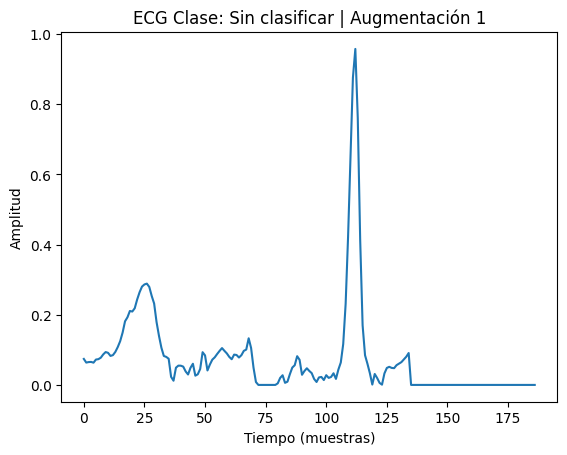

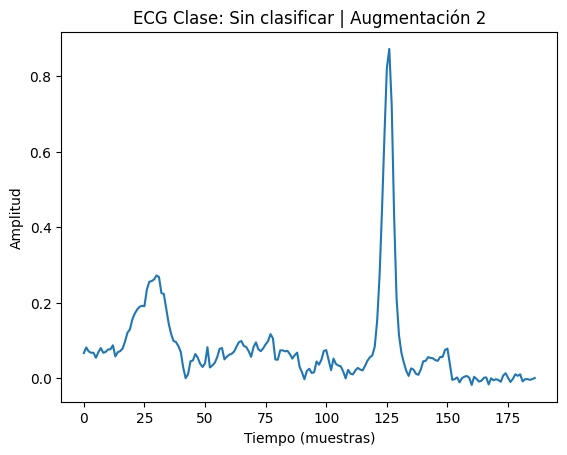

In [14]:
aug1, aug2 = simclr_augment(X_train[1])
plot_ecg(X=aug1, y=y_train[1], aug=True, aug_title="Augmentación 1")
plot_ecg(X=aug2, y=y_train[1], aug=True, aug_title="Augmentación 2")

#### **6.1.b Augmentaciones para SimCLR utilizando torch-audiomentations**

In [15]:
"""
torchaudio_augmenter = Compose([
	AddColoredNoise(p=0.5),
	TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
	PitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)
])

def simclr_tsaug_augmentation(x):
	aug1 = torchaudio_augmenter.augment(x)
	aug2 = torchaudio_augmenter.augment(x)
	return aug1, aug2
"""

'\ntorchaudio_augmenter = Compose([\n\tAddColoredNoise(p=0.5),\n\tTimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),\n\tPitchShift(min_transpose_semitones=-2, max_transpose_semitones=2, p=0.5)\n])\n\ndef simclr_tsaug_augmentation(x):\n\taug1 = torchaudio_augmenter.augment(x)\n\taug2 = torchaudio_augmenter.augment(x)\n\treturn aug1, aug2\n'

#### **6.2 Dataset para SimCLR**

In [16]:
class SimCLRDataset(Dataset):
	def __init__(self, X, y=None, transform=None, dtype=np.float32, eps=1e-6):
		self.X = np.asarray(X, dtype=dtype)
		self.y = None if y is None else np.asarray(y)
		self.transform = transform
		self.eps = eps

	def __len__(self):
		return self.X.shape[0]

	def _zscore(self, x):
		m = x.mean()
		s = x.std()
		return (x - m) / (s + self.eps)

	def __getitem__(self, index):
		x = self.X[index]

		if self.transform is not None:
			a1, a2 = self.transform(x)
		else:
			a1 = a2 = x
			
		a1 = self._zscore(np.asarray(a1, dtype=np.float32))
		a2 = self._zscore(np.asarray(a2, dtype=np.float32))

		x1 = torch.from_numpy(a1).unsqueeze(0)
		x2 = torch.from_numpy(a2).unsqueeze(0)

		if self.y is None:
			return (x1, x2)

		y = torch.as_tensor(self.y[index])
		return (x1, x2), y

In [17]:
simclr_train_dataset = SimCLRDataset(X=X_train, y=y_train, transform=simclr_augment)
simclr_test_dataset = SimCLRDataset(X=X_test, y=y_test)

#### **6.3 DataLoaders para SimCLR**

In [18]:
simclr_train_dataloader = DataLoader(
	dataset=simclr_train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
	drop_last=True,
	num_workers=NUM_WORKERS,
	pin_memory=(DEVICE.type != "cpu")
)

simclr_test_dataloader = DataLoader(
	dataset=simclr_test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
	drop_last=False,
	num_workers=NUM_WORKERS,
	pin_memory=(DEVICE.type != "cpu")
)

#### **6.4 Modelo SimCLR**

In [19]:
class CNN1DBackbone(nn.Module):
	def __init__(self):
		super().__init__()
		self.feat = nn.Sequential(
			nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
			nn.BatchNorm1d(64),
			nn.ReLU(inplace=True),

			nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2, bias=False),
			nn.BatchNorm1d(128),
			nn.ReLU(inplace=True),

			nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
			nn.BatchNorm1d(256),
			nn.ReLU(inplace=True),

			nn.AdaptiveAvgPool1d(1)
		)

	def forward(self, x):
		x = self.feat(x)
		return x.squeeze(-1)
	
class SimCLRProjectionHead(nn.Module):
	def __init__(self, in_dim, hid_dim, out_dim):
		super().__init__()
		self.net = nn.Sequential(
			nn.Linear(in_dim, hid_dim),
			nn.ReLU(inplace=True),
			nn.Linear(hid_dim, out_dim)
		)

	def forward(self, h):
		z = self.net(h)
		return F.normalize(z, dim=1)

class SimCLRModel(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.save_hyperparameters()

		self.backbone = CNN1DBackbone()
		hidden_dim = 256

		self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, PROJ_DIM)
		self.criterion = NTXentLoss()

	def forward(self, x):
		h = self.backbone(x)
		z = self.projection_head(h)
		return z

	def training_step(self, batch, batch_idx):
		if isinstance(batch, tuple) and len(batch) == 2 and isinstance(batch[0], torch.Tensor):
			x0, x1 = batch
		else:
			(x0, x1), _ = batch

		z0 = self(x0)
		z1 = self(x1)
		loss = self.criterion(z0, z1)
		self.log("training_loss_ssl", loss, prog_bar=True, on_step=False, on_epoch=True)
		return loss

	def test_step(self, batch, batch_idx):
		if isinstance(batch, tuple) and len(batch) == 2 and isinstance(batch[0], torch.Tensor):
			x0, x1 = batch
		else:
			(x0, x1), _ = batch

		z0 = self(x0)
		z1 = self(x1)
		loss = self.criterion(z0, z1)
		self.log("test_loss_ssl", loss, prog_bar=True)
		return loss

	def configure_optimizers(self):
		optim = torch.optim.SGD(
			self.parameters(),
			lr=LEARNING_RATE,
			momentum=MOMENTUM,
			weight_decay=WEIGHT_DECAY
		)
		scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
			optim,
			T_max=EPOCHS
		)
		return {
			"optimizer": optim,
			"lr_scheduler": {
				"scheduler": scheduler,
				"interval": "epoch",
				"frequency": 1
			}
		}

#### **6.5 Entrenamiento SimCLR**

In [ ]:
simclr_model = SimCLRModel()
trainer = pl.Trainer(
	max_epochs=EPOCHS,
	devices=1,
	accelerator="gpu",
	precision="16-mixed",
	benchmark=True
)
trainer.fit(
	simclr_model,
	simclr_train_dataloader
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | backbone        | CNN1DBackbone        | 140 K  | train
1 | projection_head | SimCLRProjectionHead | 98.7 K | train
2 | criterion       | NTXentLoss           | 0      | train
-----------------------------------------------------------------
239 K     Trainable params
0         Non-trainable params
239 K     Total params
0.957     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
c:\Users\cinto\Repositorios\INF395-Redes-Neuronales\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing

Epoch 3:  41%|████      | 35/85 [00:35<00:50,  0.99it/s, v_num=4, training_loss_ssl=6.210]

In [ ]:
trainer.test(
	model=simclr_model,
	dataloaders=simclr_test_dataloader,
	ckpt_path=None
)

MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.